# Machine Learning Engineer Takehome

Welcome to the evaluation project for the Machine Learning Engineer position. In this project you will evaluate a search academic dataset built using common learn-to-rank features, build a ranking model using the dataset, and discuss how additional features could be used and how they would impact the performance of the model.

Overview:
- Make a copy of this notebook.
- Download the dataset to the notebook (link in Step 2 comments)
- Preprocess and evaluate the dataset
- Build a **ranking** model
- Evaluate your ranking model using a metric of your choice
- Answer discussion questions
- Submit your notebook

# The Model

### 1) Imports

In [1]:
# Import dependencies here
import os
import modin.pandas as pd
import ray
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_ranking as tfr
import tensorflow as tf
from tensorflow_serving.apis import input_pb2

from helpers import *
from tfrecord_converter_ import SVM_to_TFRecord
from build_model import build_model

pd.options.display.max_columns = 500

ray.init()

%matplotlib inline

# Variable used in data transformations to access repsective folders
folder_num = [1,2,3,4,5]

2022-04-06 15:01:50,745	INFO services.py:1412 -- View the Ray dashboard at http://127.0.0.1:8265


### 2) Download Dataset

In [2]:
# Download the dataset located at https://storage.googleapis.com/personalization-takehome/MSLR-WEB10K.zip
# You can read about the features included in the dataset here: https://www.microsoft.com/en-us/research/project/mslr/

!wget https://storage.googleapis.com/personalization-takehome/MSLR-WEB10K.zip

In [3]:
!unzip MSLR-WEB10K.zip

In [ ]:
!unzip Archive.zip

### 3) Preprocess and evaluate the dataset

#### To kickoff this project, I'll dive into the raw data, see if I'll need to clean the data in any way, and verify data integrity across the Fold's. Let's get started!

In [4]:
df_train = pd.read_csv('Fold1/train.txt', sep=' ', header=None)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138
0,2,qid:1,1:3,2:3,3:0,4:0,5:3,6:1,7:1,8:0,9:0,10:1,11:156,12:4,13:0,14:7,15:167,16:6.931275,17:22.076928,18:19.673353,19:22.255383,20:6.926551,21:3,22:3,23:0,24:0,25:6,26:1,27:1,28:0,29:0,30:2,31:1,32:1,33:0,34:0,35:2,36:1,37:1,38:0,39:0,40:2,41:0,42:0,43:0,44:0,45:0,46:0.019231,47:0.75000,48:0,49:0,50:0.035928,51:0.00641,52:0.25000,53:0,54:0,55:0.011976,56:0.00641,57:0.25000,58:0,59:0,60:0.011976,61:0.00641,62:0.25000,63:0,64:0,65:0.011976,66:0,67:0,68:0,69:0,70:0,71:6.931275,72:22.076928,73:0,74:0,75:13.853103,76:1.152128,77:5.99246,78:0,79:0,80:2.297197,81:3.078917,82:8.517343,83:0,84:0,85:6.156595,86:2.310425,87:7.358976,88:0,89:0,90:4.617701,91:0.694726,92:1.084169,93:0,94:0,95:2.78795,96:1,97:1,98:0,99:0,100:1,101:1,102:1,103:0,104:0,105:1,106:12.941469,107:20.59276,108:0,109:0,110:16.766961,111:-18.567793,112:-7.760072,113:-20.838749,114:-25.436074,115:-14.518523,116:-21.710022,117:-21.339609,118:-24.497864,119:-27.690319,120:-20.203779,121:-15.449379,122:-4.474452,123:-23.634899,124:-28.119826,125:-13.581932,126:3,127:62,128:11089534,129:2,130:116,131:64034,132:13,133:3,134:0,135:0,136:0,NaN
1,2,qid:1,1:3,2:0,3:3,4:0,5:3,6:1,7:0,8:1,9:0,10:1,11:406,12:0,13:5,14:5,15:416,16:6.931275,17:22.076928,18:19.673353,19:22.255383,20:6.926551,21:28,22:0,23:3,24:0,25:31,26:8,27:0,28:1,29:0,30:9,31:10,32:0,33:1,34:0,35:11,36:9.333333,37:0,38:1,39:0,40:10.333333,41:0.888889,42:0,43:0,44:0,45:0.888889,46:0.068966,47:0,48:0.60000,49:0,50:0.074519,51:0.019704,52:0,53:0.20000,54:0,55:0.021635,56:0.024631,57:0,58:0.20000,59:0,60:0.026442,61:0.022989,62:0,63:0.20000,64:0,65:0.02484,66:0.000005,67:0,68:0,69:0,70:0.000005,71:63.912287,72:0,73:19.673353,74:0,75:70.792754,76:11.521285,77:0,78:5.373163,79:0,80:12.634581,81:30.789171,82:0,83:7.985784,84:0,85:33.861273,86:21.304096,87:0,88:6.557784,89:0,90:23.597585,91:61.919565,92:0,93:1.167248,94:0,95:75.339929,96:1,97:0,98:1,99:0,100:1,101:0.994425,102:0,103:1,104:0,105:0.995455,106:20.885118,107:0,108:24.233365,109:0,110:21.161666,111:-11.55585,112:-21.242171,113:-8.429024,114:-25.436074,115:-11.297811,116:-16.487275,117:-24.805464,118:-21.461317,119:-27.690319,120:-16.208808,121:-11.646141,122:-24.041386,123:-5.14386,124:-28.119826,125:-11.411068,126:2,127:54,128:11089534,129:2,130:124,131:64034,132:1,133:2,134:0,135:0,136:0,NaN
2,0,qid:1,1:3,2:0,3:2,4:0,5:3,6:1,7:0,8:0.666667,9:0,10:1,11:146,12:0,13:3,14:7,15:156,16:6.931275,17:22.076928,18:19.673353,19:22.255383,20:6.926551,21:14,22:0,23:2,24:0,25:16,26:1,27:0,28:0,29:0,30:1,31:7,32:0,33:1,34:0,35:8,36:4.666667,37:0,38:0.666667,39:0,40:5.333333,41:6.888889,42:0,43:0.222222,44:0,45:9.555556,46:0.09589,47:0,48:0.666667,49:0,50:0.102564,51:0.006849,52:0,53:0,54:0,55:0.00641,56:0.047945,57:0,58:0.333333,59:0,60:0.051282,61:0.031963,62:0,63:0.222222,64:0,65:0.034188,66:0.000323,67:0,68:0.024691,69:0,70:0.000393,71:29.238631,72:0,73:11.687569,74:0,75:33.436525,76:2.700229,77:0,78:0,79:0,80:2.699655,81:18.473503,82:0,83:6.314406,84:0,85:21.548083,86:9.74621,87:0,88:3.895856,89:0,90:11.145508,91:42.879431,92:0,93:7.736505,94:0,95:61.124916,96:1,97:0,98:0,99:0,100:1,101:0.851903,102:0,103:0.720414,104:0,105:0.842789,106:18.140878,107:0,108:17.748073,109:0,110:18.279205,111:-12.609065,112:-21.242171,113:-14.935056,114:-25.436074,115:-12.487989,116:-18.832941,117:-24.805464,118:-23.925663,119:-27.690319,120:-18.589543,121:-11.525277,122:-24.041386,123:-14.689844,124:-28.119826,125:-11.436378,126:3,127:45,128:3,129:1,130:124,131:3344,132:14,133:67,134:0,135:0,136:0,NaN
3,2,qid:1,1:3,2:0,3:3,4:0,5:3,6:1,7:0,8:1,9

In [5]:
df_test = pd.read_csv('Fold3/test.txt', sep=' ', header=None)
df_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138
0,0,qid:4,1:3,2:0,3:2,4:0,5:3,6:1,7:0,8:0.666667,9:0,10:1,11:999,12:0,13:110,14:5,15:1114,16:14.976692,17:28.949002,18:25.594644,19:28.531344,20:14.972391,21:20,22:0,23:5,24:0,25:25,26:1,27:0,28:0,29:0,30:1,31:12,32:0,33:4,34:0,35:16,36:6.666667,37:0,38:1.666667,39:0,40:8.333333,41:20.222222,42:0,43:2.888889,44:0,45:37.555556,46:0.02002,47:0,48:0.045455,49:0,50:0.022442,51:0.001001,52:0,53:0,54:0,55:0.000898,56:0.012012,57:0,58:0.036364,59:0,60:0.014363,61:0.006673,62:0,63:0.015152,64:0,65:0.007481,66:0.00002,67:0,68:0.000239,69:0,70:0.00003,71:77.577533,72:0,73:30.667985,74:0,75:90.53171,76:5.52713,77:0,78:0,79:0,80:5.526745,81:57.882066,82:0,83:18.750101,84:0,85:66.125373,86:25.859178,87:0,88:10.222662,89:0,90:30.177237,91:525.177766,92:0,93:60.031269,94:0,95:675.850674,96:1,97:0,98:0,99:0,100:1,101:0.875901,102:0,103:0.66135,104:0,105:0.864571,106:28.756809,107:0,108:3.274639,109:0,110:28.985515,111:-17.640291,112:-29.251906,113:-20.596041,114:-31.107208,115:-17.519629,116:-19.440921,117:-31.580405,118:-24.146168,119:-33.960286,120:-19.161514,121:-16.596977,122:-31.750477,123:-21.267965,124:-33.908554,125:-16.503638,126:2,127:27,128:2,129:9,130:124,131:4678,132:54,133:74,134:0,135:0,136:0,NaN
1,0,qid:4,1:3,2:0,3:3,4:0,5:3,6:1,7:0,8:1,9:0,10:1,11:1561,12:2,13:34,14:10,15:1607,16:14.976692,17:28.949002,18:25.594644,19:28.531344,20:14.972391,21:116,22:0,23:5,24:0,25:121,26:25,27:0,28:1,29:0,30:27,31:46,32:0,33:2,34:0,35:47,36:38.666667,37:0,38:1.666667,39:0,40:40.333333,41:93.555556,42:0,43:0.222222,44:0,45:88.888889,46:0.074311,47:0,48:0.147059,49:0,50:0.075296,51:0.016015,52:0,53:0.029412,54:0,55:0.016801,56:0.029468,57:0,58:0.058824,59:0,60:0.029247,61:0.02477,62:0,63:0.04902,64:0,65:0.025099,66:0.000038,67:0,68:0.000192,69:0,70:0.000034,71:514.100919,72:0,73:42.200053,74:0,75:538.388954,76:53.131263,77:0,78:8.989234,79:0,80:55.45880,81:254.247991,82:0,83:23.835768,84:0,85:259.75702,86:171.366973,87:0,88:14.066684,89:0,90:179.462985,91:7366.300194,92:0,93:47.742308,94:0,95:7911.58233,96:1,97:0,98:1,99:0,100:1,101:0.955621,102:0,103:0.962572,104:0,105:0.963078,106:46.223212,107:0,108:12.964064,109:0,110:46.49829,111:-11.259261,112:-29.251906,113:-11.236469,114:-31.107208,115:-11.201481,116:-13.644195,117:-31.580405,118:-20.489491,119:-33.960286,120:-13.542059,121:-11.518063,122:-31.750477,123:-9.505871,124:-33.908554,125:-11.463268,126:2,127:61,128:0,129:8,130:122,131:508,132:131,133:136,134:0,135:0,136:0,NaN
2,0,qid:4,1:3,2:0,3:2,4:0,5:3,6:1,7:0,8:0.666667,9:0,10:1,11:1029,12:0,13:110,14:6,15:1145,16:14.976692,17:28.949002,18:25.594644,19:28.531344,20:14.972391,21:18,22:0,23:5,24:0,25:23,26:1,27:0,28:0,29:0,30:1,31:10,32:0,33:4,34:0,35:14,36:6,37:0,38:1.666667,39:0,40:7.666667,41:14,42:0,43:2.888889,44:0,45:28.222222,46:0.017493,47:0,48:0.045455,49:0,50:0.020087,51:0.000972,52:0,53:0,54:0,55:0.000873,56:0.009718,57:0,58:0.036364,59:0,60:0.012227,61:0.005831,62:0,63:0.015152,64:0,65:0.006696,66:0.000013,67:0,68:0.000239,69:0,70:0.000022,71:75.216144,72:0,73:30.667985,74:0,75:88.171761,76:5.52713,77:0,78:0,79:0,80:5.526745,81:57.882066,82:0,83:18.750101,84:0,85:66.125373,86:25.072048,87:0,88:10.222662,89:0,90:29.390587,91:544.821332,92:0,93:60.031269,94:0,95:694.862886,96:1,97:0,98:0,99:0,100:1,101:0.880123,102:0,103:0.66135,104:0,105:0.869781,106:28.376489,107:0,108:3.274639,109:0,110:28.675516,111:-17.920854,112:-29.251906,113:-20.596041,114:-31.107208,115:-17.740301,116:-19.630119,117:-31.580405,118:-24.146168,119:-33.960286,120:-19.311966,121:-16.866315,122:-31.750477,123:-21.267965,

In [6]:
df_val = pd.read_csv('Fold5/vali.txt', sep=' ', header=None)
df_val.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138
0,0,qid:7,1:2,2:0,3:2,4:0,5:2,6:0.666667,7:0,8:0.666667,9:0,10:0.666667,11:90,12:0,13:12,14:11,15:113,16:8.910414,17:22.625881,18:19.191275,19:21.20707,20:8.902562,21:4,22:0,23:2,24:0,25:6,26:0,27:0,28:0,29:0,30:0,31:2,32:0,33:1,34:0,35:3,36:1.333333,37:0,38:0.666667,39:0,40:2,41:0.888889,42:0,43:0.222222,44:0,45:2,46:0.044444,47:0,48:0.166667,49:0,50:0.053097,51:0,52:0,53:0,54:0,55:0,56:0.022222,57:0,58:0.083333,59:0,60:0.026549,61:0.014815,62:0,63:0.055556,64:0,65:0.017699,66:0.00011,67:0,68:0.001543,69:0,70:0.000157,71:13.319451,72:0,73:13.287071,74:0,75:19.959059,76:0,77:0,78:0,79:0,80:0,81:7.961634,82:0,83:7.185853,84:0,85:11.924014,86:4.439817,87:0,88:4.429024,89:0,90:6.65302,91:10.985964,92:0,93:10.004198,94:0,95:24.652015,96:0,97:0,98:0,99:0,100:0,101:0.899896,102:0,103:0.847431,104:0,105:0.899785,106:17.163685,107:0,108:9.854027,109:0,110:18.553862,111:-17.403359,112:-22.088039,113:-15.593347,114:-23.36806,115:-16.835567,116:-22.130058,117:-24.71149,118:-22.356952,119:-25.950683,120:-21.42488,121:-18.552093,122:-24.72900,123:-15.354324,124:-26.166332,125:-18.193633,126:7,127:63,128:1,129:1,130:124,131:59997,132:17,133:3,134:0,135:0,136:0,NaN
1,0,qid:7,1:3,2:0,3:1,4:0,5:3,6:1,7:0,8:0.333333,9:0,10:1,11:259,12:0,13:13,14:6,15:278,16:8.910414,17:22.625881,18:19.191275,19:21.20707,20:8.902562,21:34,22:0,23:1,24:0,25:35,26:1,27:0,28:0,29:0,30:1,31:30,32:0,33:1,34:0,35:31,36:11.333333,37:0,38:0.333333,39:0,40:11.666667,41:174.888889,42:0,43:0.222222,44:0,45:187.555556,46:0.131274,47:0,48:0.076923,49:0,50:0.125899,51:0.003861,52:0,53:0,54:0,55:0.003597,56:0.11583,57:0,58:0.076923,59:0,60:0.111511,61:0.043758,62:0,63:0.025641,64:0,65:0.041966,66:0.002607,67:0,68:0.001315,69:0,70:0.002427,71:91.100137,72:0,73:6.101218,74:0,75:93.752105,76:3.980817,77:0,78:0,79:0,80:3.974671,81:80.367255,82:0,83:6.101218,84:0,85:83.028807,86:30.366712,87:0,88:2.033739,89:0,90:31.250702,91:1251.307108,92:0,93:8.272192,94:0,95:1341.768558,96:1,97:0,98:0,99:0,100:1,101:0.579852,102:0,103:0.548569,104:0,105:0.578012,106:21.337958,107:0,108:4.281432,109:0,110:21.19097,111:-13.642907,112:-22.088039,113:-21.424354,114:-23.36806,115:-13.820535,116:-18.428115,117:-24.71149,118:-24.043444,119:-25.950683,120:-18.418609,121:-12.483104,122:-24.72900,123:-24.22759,124:-26.166332,125:-12.662394,126:2,127:32,128:0,129:0,130:119,131:13,132:12,133:76,134:0,135:0,136:0,NaN
2,1,qid:7,1:3,2:0,3:0,4:0,5:3,6:1,7:0,8:0,9:0,10:1,11:54,12:0,13:2,14:13,15:69,16:8.910414,17:22.625881,18:19.191275,19:21.20707,20:8.902562,21:11,22:0,23:0,24:0,25:11,26:1,27:0,28:0,29:0,30:1,31:7,32:0,33:0,34:0,35:7,36:3.666667,37:0,38:0,39:0,40:3.666667,41:6.222222,42:0,43:0,44:0,45:6.222222,46:0.203704,47:0,48:0,49:0,50:0.15942,51:0.018519,52:0,53:0,54:0,55:0.014493,56:0.12963,57:0,58:0,59:0,60:0.101449,61:0.067901,62:0,63:0,64:0,65:0.05314,66:0.002134,67:0,68:0,69:0,70:0.001307,71:32.945498,72:0,73:0,74:0,75:32.921996,76:2.250688,77:0,78:0,79:0,80:2.249542,81:18.75236,82:0,83:0,84:0,85:18.74844,86:10.981833,87:0,88:0,89:0,90:10.973999,91:45.845585,92:0,93:0,94:0,95:45.820203,96:1,97:0,98:0,99:0,100:1,101:0.865522,102:0,103:0,104:0,105:0.865457,106:24.952048,107:0,108:0,109:0,110:24.699091,111:-10.475695,112:-22.088039,113:-21.585091,114:-23.36806,115:-11.20559,116:-19.383403,117:-24.71149,118:-24.096086,119:-25.950683,120:-19.403478,121:-9.236917,122:-24.72900,123:-24.390086,124:-26.166332,125:-9.971833,126:6,127:81,128:23,129:0,130:267,131:34417,132:14,133:8,134:0,135:0,136:0,NaN
3,1,qid:7,1:3,2:0,3:3,4:3,5:3,6:1,7:0,8:1,9:1,10:1,11:785,12:0,13:13,14

#### Randomly choosing three datasets, one for each split, we can see the datasets all look identical. Excluding column 0, all columns have a prefix associated to their feature number. 

#### Per the [Microsoft webpage](https://www.microsoft.com/en-us/research/project/mslr/), the first column represents the relevance value (ranked 0-5 with 0 being the most irrelevant), the second column is the query id, and the remaning columns are features. In the below cell, I will rename the first two columns, map the remaiing features from the features.csv file, remove the prefixes, and save the files in CSV format. All CSV's are stored in their respective folders.

#### Note: This function does not include any try/except statements so if my assumption of all files being identical is wrong an error will be returned. 

#### Note: All functions in this section are stored in the helpers.py file.

In [7]:
# Renaming the columns and saving as CSV
load_rename_save(folder_num)

Data types of partitions are different! Please refer to the troubleshooting section of the Modin documentation to fix this issue.
(pid=45092) [2022-04-06 12:44:17,490 E 45092 45119] core_worker_process.cc:347: The global worker has already been shutdown. This happens when the language frontend accesses the Ray's worker after it is shutdown. The process will exit
(pid=46493) [2022-04-06 12:52:20,618 E 46493 46533] core_worker_process.cc:347: The global worker has already been shutdown. This happens when the language frontend accesses the Ray's worker after it is shutdown. The process will exit
(pid=47517) [2022-04-06 12:58:40,661 E 47517 47731] core_worker_process.cc:347: The global worker has already been shutdown. This happens when the language frontend accesses the Ray's worker after it is shutdown. The process will exit
(pid=47514) [2022-04-06 12:58:40,578 E 47514 47694] core_worker_process.cc:347: The global worker has already been shutdown. This happens when the language frontend 

In [8]:
df = pd.read_csv('Fold3/df_train.csv')
df

,relevance_label,query_id,covered_query_term_number_body,covered_query_term_number_anchor,covered_query_term_number_title,covered_query_term_number_url,covered_query_term_number_whole_document,covered_query_term_ratio_body,covered_query_term_ratio_anchor,covered_query_term_ratio_title,covered_query_term_ratio_url,covered_query_term_ratio_whole_document,stream_length_body,stream_length_anchor,stream_length_title,stream_length_url,stream_length_whole_document,IDF_Inverse_document_frequency__body,IDF_Inverse_document_frequency__anchor,IDF_Inverse_document_frequency__title,IDF_Inverse_document_frequency__url,IDF_Inverse_document_frequency__whole_document,sum_of_term_frequency_body,sum_of_term_frequency_anchor,sum_of_term_frequency_title,sum_of_term_frequency_url,sum_of_term_frequency_whole_document,min_of_term_frequency_body,min_of_term_frequency_anchor,min_of_term_frequency_title,min_of_term_frequency_url,min_of_term_frequency_whole_document,max_of_term_frequency_body,max_of_term_frequency_anchor,max_of_term_frequency_title,max_of_term_frequency_url,max_of_term_frequency_whole_document,mean_of_term_frequency_body,mean_of_term_frequency_anchor,mean_of_term_frequency_title,mean_of_term_frequency_url,mean_of_term_frequency_whole_document,variance_of_term_frequency_body,variance_of_term_frequency_anchor,variance_of_term_frequency_title,variance_of_term_frequency_url,variance_of_term_frequency_whole_document,sum_of_stream_length_normalized_term_frequency_body,sum_of_stream_length_normalized_term_frequency_anchor,sum_of_stream_length_normalized_term_frequency_title,sum_of_stream_length_normalized_term_frequency_url,sum_of_stream_length_normalized_term_frequency_whole_document,min_of_stream_length_normalized_term_frequency_body,min_of_stream_length_normalized_term_frequency_anchor,min_of_stream_length_normalized_term_frequency_title,min_of_stream_length_normalized_term_frequency_url,min_of_stream_length_normalized_term_frequency_whole_document,max_of_stream_length_normalized_term_frequency_body,max_of_stream_length_normalized_term_frequency_anchor,max_of_stream_length_normalized_term_frequency_title,max_of_stream_length_normalized_term_frequency_url,max_of_stream_length_normalized_term_frequency_whole_document,mean_of_stream_length_normalized_term_frequency_body,mean_of_stream_length_normalized_term_frequency_anchor,mean_of_stream_length_normalized_term_frequency_title,mean_of_stream_length_normalized_term_frequency_url,mean_of_stream_length_normalized_term_frequency_whole_document,variance_of_stream_length_normalized_term_frequency_body,variance_of_stream_length_normalized_term_frequency_anchor,variance_of_stream_length_normalized_term_frequency_title,variance_of_stream_length_normalized_term_frequency_url,variance_of_stream_length_normalized_term_frequency_whole_document,sum_of_tf_idf_body,sum_of_tf_idf_anchor,sum_of_tf_idf_title,sum_of_tf_idf_url,sum_of_tf_idf_whole_document,min_of_tf_idf_body,min_of_tf_idf_anchor,min_of_tf_idf_title,min_of_tf_idf_url,min_of_tf_idf_whole_document,max_of_tf_idf_body,max_of_tf_idf_anchor,max_of_tf_idf_title,max_of_tf_idf_url,max_of_tf_idf_whole_document,mean_of_tf_idf_body,mean_of_tf_idf_anchor,mean_of_tf_idf_title,mean_of_tf_idf_url,mean_of_tf_idf_whole_document,variance_of_tf_idf_body,variance_of_tf_idf_anchor,variance_of_tf_idf_title,variance_of_tf_idf_url,variance_of_tf_idf_whole_document,boolean_model_body,boolean_model_anchor,boolean_model_title,boolean_model_url,boolean_model_whole_document,vector_space_model_body,vector_space_model_anchor,vector_space_model_title,vector_space_model_url,vector_space_model_whole_document,BM25_body,BM25_anchor,BM25_title,BM25_url,BM25_whole_document,LMIR.ABS_body,LMIR.ABS_anchor,LMIR.ABS_title,LMIR.ABS_url,LMIR.ABS_whole_document,LMIR.DIR_body,LMIR.DIR_anchor,LMIR.DIR_title,LMIR.DIR_url,LMIR.DIR_whole_document,LMIR.JM_body,LMIR.JM_anchor,LMIR.JM_title,LMIR.JM_url,LMIR.JM_whole_document,Number_of_slash_in_URL,Length_of_URL,Inlink_number,Outlink_number,PageRank,Site

#### Above we can see that we did not get any errors which means our assumption is true that all dataframes are identical. Next we will verify our column types to make sure they registered as integers and floats and are not set to strings. 

In [9]:
df.select_dtypes(['int', 'float'])

,relevance_label,query_id,covered_query_term_number_body,covered_query_term_number_anchor,covered_query_term_number_title,covered_query_term_number_url,covered_query_term_number_whole_document,covered_query_term_ratio_body,covered_query_term_ratio_anchor,covered_query_term_ratio_title,covered_query_term_ratio_url,covered_query_term_ratio_whole_document,stream_length_body,stream_length_anchor,stream_length_title,stream_length_url,stream_length_whole_document,IDF_Inverse_document_frequency__body,IDF_Inverse_document_frequency__anchor,IDF_Inverse_document_frequency__title,IDF_Inverse_document_frequency__url,IDF_Inverse_document_frequency__whole_document,sum_of_term_frequency_body,sum_of_term_frequency_anchor,sum_of_term_frequency_title,sum_of_term_frequency_url,sum_of_term_frequency_whole_document,min_of_term_frequency_body,min_of_term_frequency_anchor,min_of_term_frequency_title,min_of_term_frequency_url,min_of_term_frequency_whole_document,max_of_term_frequency_body,max_of_term_frequency_anchor,max_of_term_frequency_title,max_of_term_frequency_url,max_of_term_frequency_whole_document,mean_of_term_frequency_body,mean_of_term_frequency_anchor,mean_of_term_frequency_title,mean_of_term_frequency_url,mean_of_term_frequency_whole_document,variance_of_term_frequency_body,variance_of_term_frequency_anchor,variance_of_term_frequency_title,variance_of_term_frequency_url,variance_of_term_frequency_whole_document,sum_of_stream_length_normalized_term_frequency_body,sum_of_stream_length_normalized_term_frequency_anchor,sum_of_stream_length_normalized_term_frequency_title,sum_of_stream_length_normalized_term_frequency_url,sum_of_stream_length_normalized_term_frequency_whole_document,min_of_stream_length_normalized_term_frequency_body,min_of_stream_length_normalized_term_frequency_anchor,min_of_stream_length_normalized_term_frequency_title,min_of_stream_length_normalized_term_frequency_url,min_of_stream_length_normalized_term_frequency_whole_document,max_of_stream_length_normalized_term_frequency_body,max_of_stream_length_normalized_term_frequency_anchor,max_of_stream_length_normalized_term_frequency_title,max_of_stream_length_normalized_term_frequency_url,max_of_stream_length_normalized_term_frequency_whole_document,mean_of_stream_length_normalized_term_frequency_body,mean_of_stream_length_normalized_term_frequency_anchor,mean_of_stream_length_normalized_term_frequency_title,mean_of_stream_length_normalized_term_frequency_url,mean_of_stream_length_normalized_term_frequency_whole_document,variance_of_stream_length_normalized_term_frequency_body,variance_of_stream_length_normalized_term_frequency_anchor,variance_of_stream_length_normalized_term_frequency_title,variance_of_stream_length_normalized_term_frequency_url,variance_of_stream_length_normalized_term_frequency_whole_document,sum_of_tf_idf_body,sum_of_tf_idf_anchor,sum_of_tf_idf_title,sum_of_tf_idf_url,sum_of_tf_idf_whole_document,min_of_tf_idf_body,min_of_tf_idf_anchor,min_of_tf_idf_title,min_of_tf_idf_url,min_of_tf_idf_whole_document,max_of_tf_idf_body,max_of_tf_idf_anchor,max_of_tf_idf_title,max_of_tf_idf_url,max_of_tf_idf_whole_document,mean_of_tf_idf_body,mean_of_tf_idf_anchor,mean_of_tf_idf_title,mean_of_tf_idf_url,mean_of_tf_idf_whole_document,variance_of_tf_idf_body,variance_of_tf_idf_anchor,variance_of_tf_idf_title,variance_of_tf_idf_url,variance_of_tf_idf_whole_document,boolean_model_body,boolean_model_anchor,boolean_model_title,boolean_model_url,boolean_model_whole_document,vector_space_model_body,vector_space_model_anchor,vector_space_model_title,vector_space_model_url,vector_space_model_whole_document,BM25_body,BM25_anchor,BM25_title,BM25_url,BM25_whole_document,LMIR.ABS_body,LMIR.ABS_anchor,LMIR.ABS_title,LMIR.ABS_url,LMIR.ABS_whole_document,LMIR.DIR_body,LMIR.DIR_anchor,LMIR.DIR_title,LMIR.DIR_url,LMIR.DIR_whole_document,LMIR.JM_body,LMIR.JM_anchor,LMIR.JM_title,LMIR.JM_url,LMIR.JM_whole_document,Number_of_slash_in_URL,Length_of_URL,Inlink_number,Outlink_number,PageRank,Site

In [10]:
df.select_dtypes('object')

Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


""
0
1
2
3
4
...
719106
719107
719108
719109


#### Our dataframe looks good so far. Next we will gather basic stats on the dataset. We will see the distribution across the train/test/val sets, if any columns have NaN values, and see the distribution of the relevance column. Later on we will dive deeper into the features but, for now, this will give us insight on if we need to redistribute the datasets or possibly remove columns.

In [11]:
# Checking for NaN values & split percentages  
data_stats(folder_num)

************************ Folder Number 1 ************************
Total rows in training set 1: 723412
Total rows in testing set 1: 241521
Total rows in validation set 1: 235259
The training set contains 0.603% of the total data
The testing set contains 0.201% of the total data
The validation set contains 0.196% of the total data
df_train_ Column feature_137 is missing [1.]% of its data
df_test_ Column feature_137 is missing [1.]% of its data
df_val_ Column feature_137 is missing [1.]% of its data
**************** df_train Relevance Class Balance ****************
Rank 0: Total Count: 377957 Percentage: 0.522
Rank 1: Total Count: 232569 Percentage: 0.321
Rank 2: Total Count: 95082 Percentage: 0.131
Rank 3: Total Count: 12658 Percentage: 0.017
Rank 4: Total Count: 5146 Percentage: 0.007
**************** df_test Relevance Class Balance ****************
Rank 0: Total Count: 124784 Percentage: 0.517
Rank 1: Total Count: 77896 Percentage: 0.323
Rank 2: Total Count: 32459 Percentage: 0.134
Ra

**************** df_val Relevance Class Balance ****************
Rank 0: Total Count: 121522 Percentage: 0.517
Rank 1: Total Count: 75815 Percentage: 0.322
Rank 2: Total Count: 31910 Percentage: 0.136
Rank 3: Total Count: 4209 Percentage: 0.018
Rank 4: Total Count: 1803 Percentage: 0.008
 
************************ Folder Number 2 ************************
Total rows in training set 2: 716683
Total rows in testing set 2: 241988
Total rows in validation set 2: 241521
The training set contains 0.597% of the total data
The testing set contains 0.202% of the total data
The validation set contains 0.201% of the total data
df_train_ Column feature_137 is missing [1.]% of its data
df_test_ Column feature_137 is missing [1.]% of its data
df_val_ Column feature_137 is missing [1.]% of its data
**************** df_train Relevance Class Balance ****************
Rank 0: Total Count: 373029 Percentage: 0.52
Rank 1: Total Count: 230368 Percentage: 0.321
Rank 2: Total Count: 95117 Percentage: 0.133
Ran

**************** df_test Relevance Class Balance ****************
Rank 0: Total Count: 126450 Percentage: 0.523
Rank 1: Total Count: 78016 Percentage: 0.322
Rank 2: Total Count: 31875 Percentage: 0.132
Rank 3: Total Count: 4053 Percentage: 0.017
Rank 4: Total Count: 1594 Percentage: 0.007
**************** df_val Relevance Class Balance ****************
Rank 0: Total Count: 124784 Percentage: 0.517
Rank 1: Total Count: 77896 Percentage: 0.323
Rank 2: Total Count: 32459 Percentage: 0.134
Rank 3: Total Count: 4450 Percentage: 0.018
Rank 4: Total Count: 1932 Percentage: 0.008
 
************************ Folder Number 3 ************************
Total rows in training set 3: 719111
Total rows in testing set 3: 239093
Total rows in validation set 3: 241988
The training set contains 0.599% of the total data
The testing set contains 0.199% of the total data
The validation set contains 0.202% of the total data
df_train_ Column feature_137 is missing [1.]% of its data
df_test_ Column feature_137 i

Rank 4: Total Count: 1769 Percentage: 0.007
**************** df_val Relevance Class Balance ****************
Rank 0: Total Count: 126450 Percentage: 0.523
Rank 1: Total Count: 78016 Percentage: 0.322
Rank 2: Total Count: 31875 Percentage: 0.132
Rank 3: Total Count: 4053 Percentage: 0.017
Rank 4: Total Count: 1594 Percentage: 0.007
 
************************ Folder Number 4 ************************
Total rows in training set 4: 718768
Total rows in testing set 4: 242331
Total rows in validation set 4: 239093
The training set contains 0.599% of the total data
The testing set contains 0.202% of the total data
The validation set contains 0.199% of the total data
df_train_ Column feature_137 is missing [1.]% of its data
df_test_ Column feature_137 is missing [1.]% of its data
df_val_ Column feature_137 is missing [1.]% of its data
**************** df_train Relevance Class Balance ****************
Rank 0: Total Count: 372756 Percentage: 0.519
Rank 1: Total Count: 231727 Percentage: 0.322
Ran

Rank 0: Total Count: 125419 Percentage: 0.518
Rank 1: Total Count: 78591 Percentage: 0.324
Rank 2: Total Count: 32294 Percentage: 0.133
Rank 3: Total Count: 4244 Percentage: 0.018
Rank 4: Total Count: 1783 Percentage: 0.007
**************** df_val Relevance Class Balance ****************
Rank 0: Total Count: 126088 Percentage: 0.527
Rank 1: Total Count: 75962 Percentage: 0.318
Rank 2: Total Count: 30913 Percentage: 0.129
Rank 3: Total Count: 4361 Percentage: 0.018
Rank 4: Total Count: 1769 Percentage: 0.007
 
************************ Folder Number 5 ************************
Total rows in training set 5: 722602
Total rows in testing set 5: 235259
Total rows in validation set 5: 242331
The training set contains 0.602% of the total data
The testing set contains 0.196% of the total data
The validation set contains 0.202% of the total data
df_train_ Column feature_137 is missing [1.]% of its data
df_test_ Column feature_137 is missing [1.]% of its data
df_val_ Column feature_137 is missing 

**************** df_test Relevance Class Balance ****************
Rank 0: Total Count: 121522 Percentage: 0.517
Rank 1: Total Count: 75815 Percentage: 0.322
Rank 2: Total Count: 31910 Percentage: 0.136
Rank 3: Total Count: 4209 Percentage: 0.018
Rank 4: Total Count: 1803 Percentage: 0.008
**************** df_val Relevance Class Balance ****************
Rank 0: Total Count: 125419 Percentage: 0.518
Rank 1: Total Count: 78591 Percentage: 0.324
Rank 2: Total Count: 32294 Percentage: 0.133
Rank 3: Total Count: 4244 Percentage: 0.018
Rank 4: Total Count: 1783 Percentage: 0.007
 


#### Reviewing the above output, we can see that all datasets are balanced identically with a 60/20/20 split, all datasets are missing 100% of the values from feature_137, and the relevance class is highly imbalanced showing a left skew. As the dataset's are balanced we do not need to be concerned about redistributing the datasets. 

#### Below is a visualition of the distribution of labels within the relevance_label column showing the imbalance across all of Fold1. As you can see, there is a drastic difference between complete irrelevant (0) and highly relevant (4). 

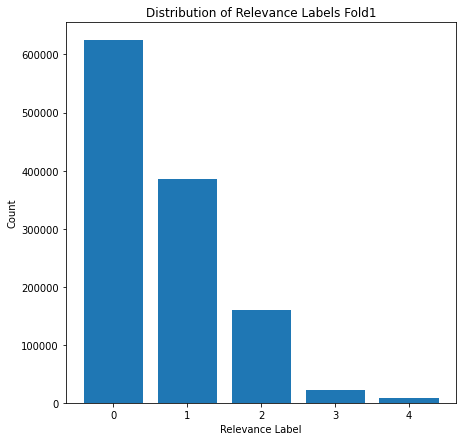

In [12]:
df = build_complete_dataset(1)
plt.figure(figsize=(7,7))
plt.bar(sorted(list(df['relevance_label'].unique())), df['relevance_label'].value_counts())
plt.title('Distribution of Relevance Labels Fold1')
plt.xlabel('Relevance Label')
plt.ylabel('Count')
plt.show();

#### Next, we will use the helper function to drop feature_137 across all dataframes.

In [13]:
# Dropping feature_137 from all datasets

drop_unwanted_cols(folder_num)

Finished Cleaning Fold1
Finished Cleaning Fold2
Finished Cleaning Fold3
Finished Cleaning Fold4
Finished Cleaning Fold5


#### Now that we have our dataframes cleaned up, lets review the distributions across the feature columns.

##### Note: I removed the query id and relevenace label as I'm only concerned with the features at this point. 

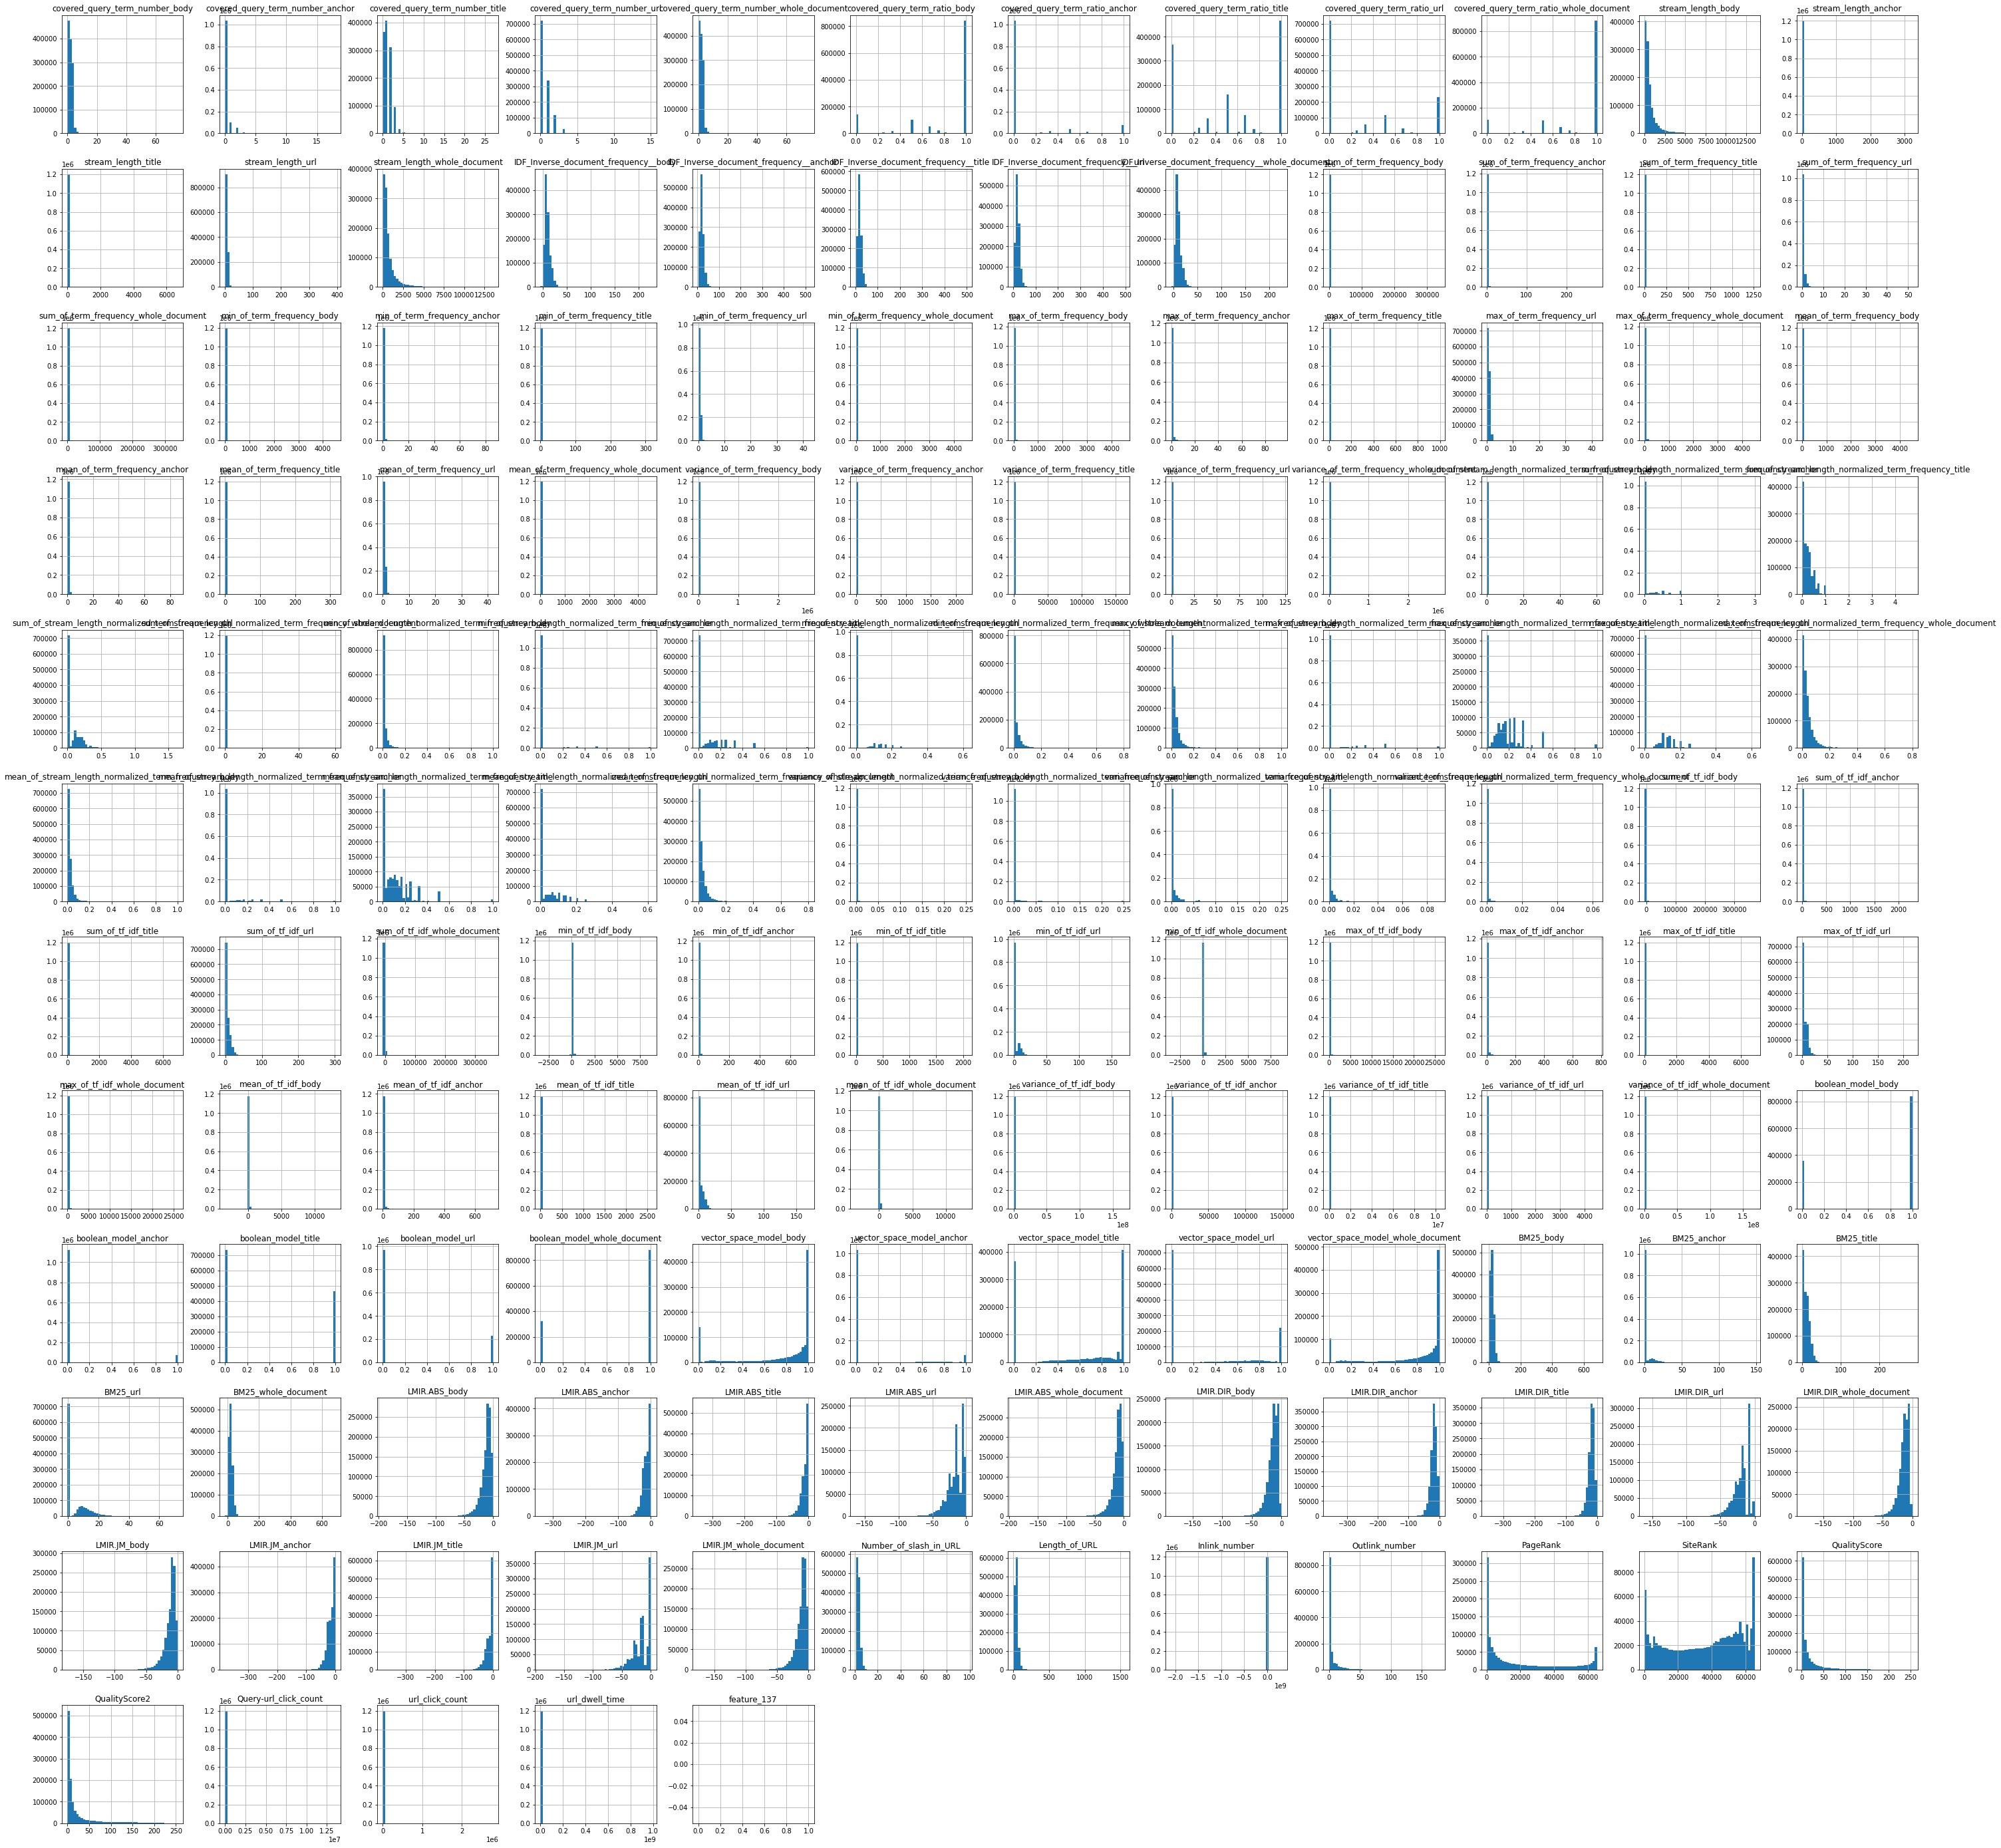

In [14]:
df_features = df[df.columns[2:]]
df_features.hist(figsize=(50,50), bins=50);

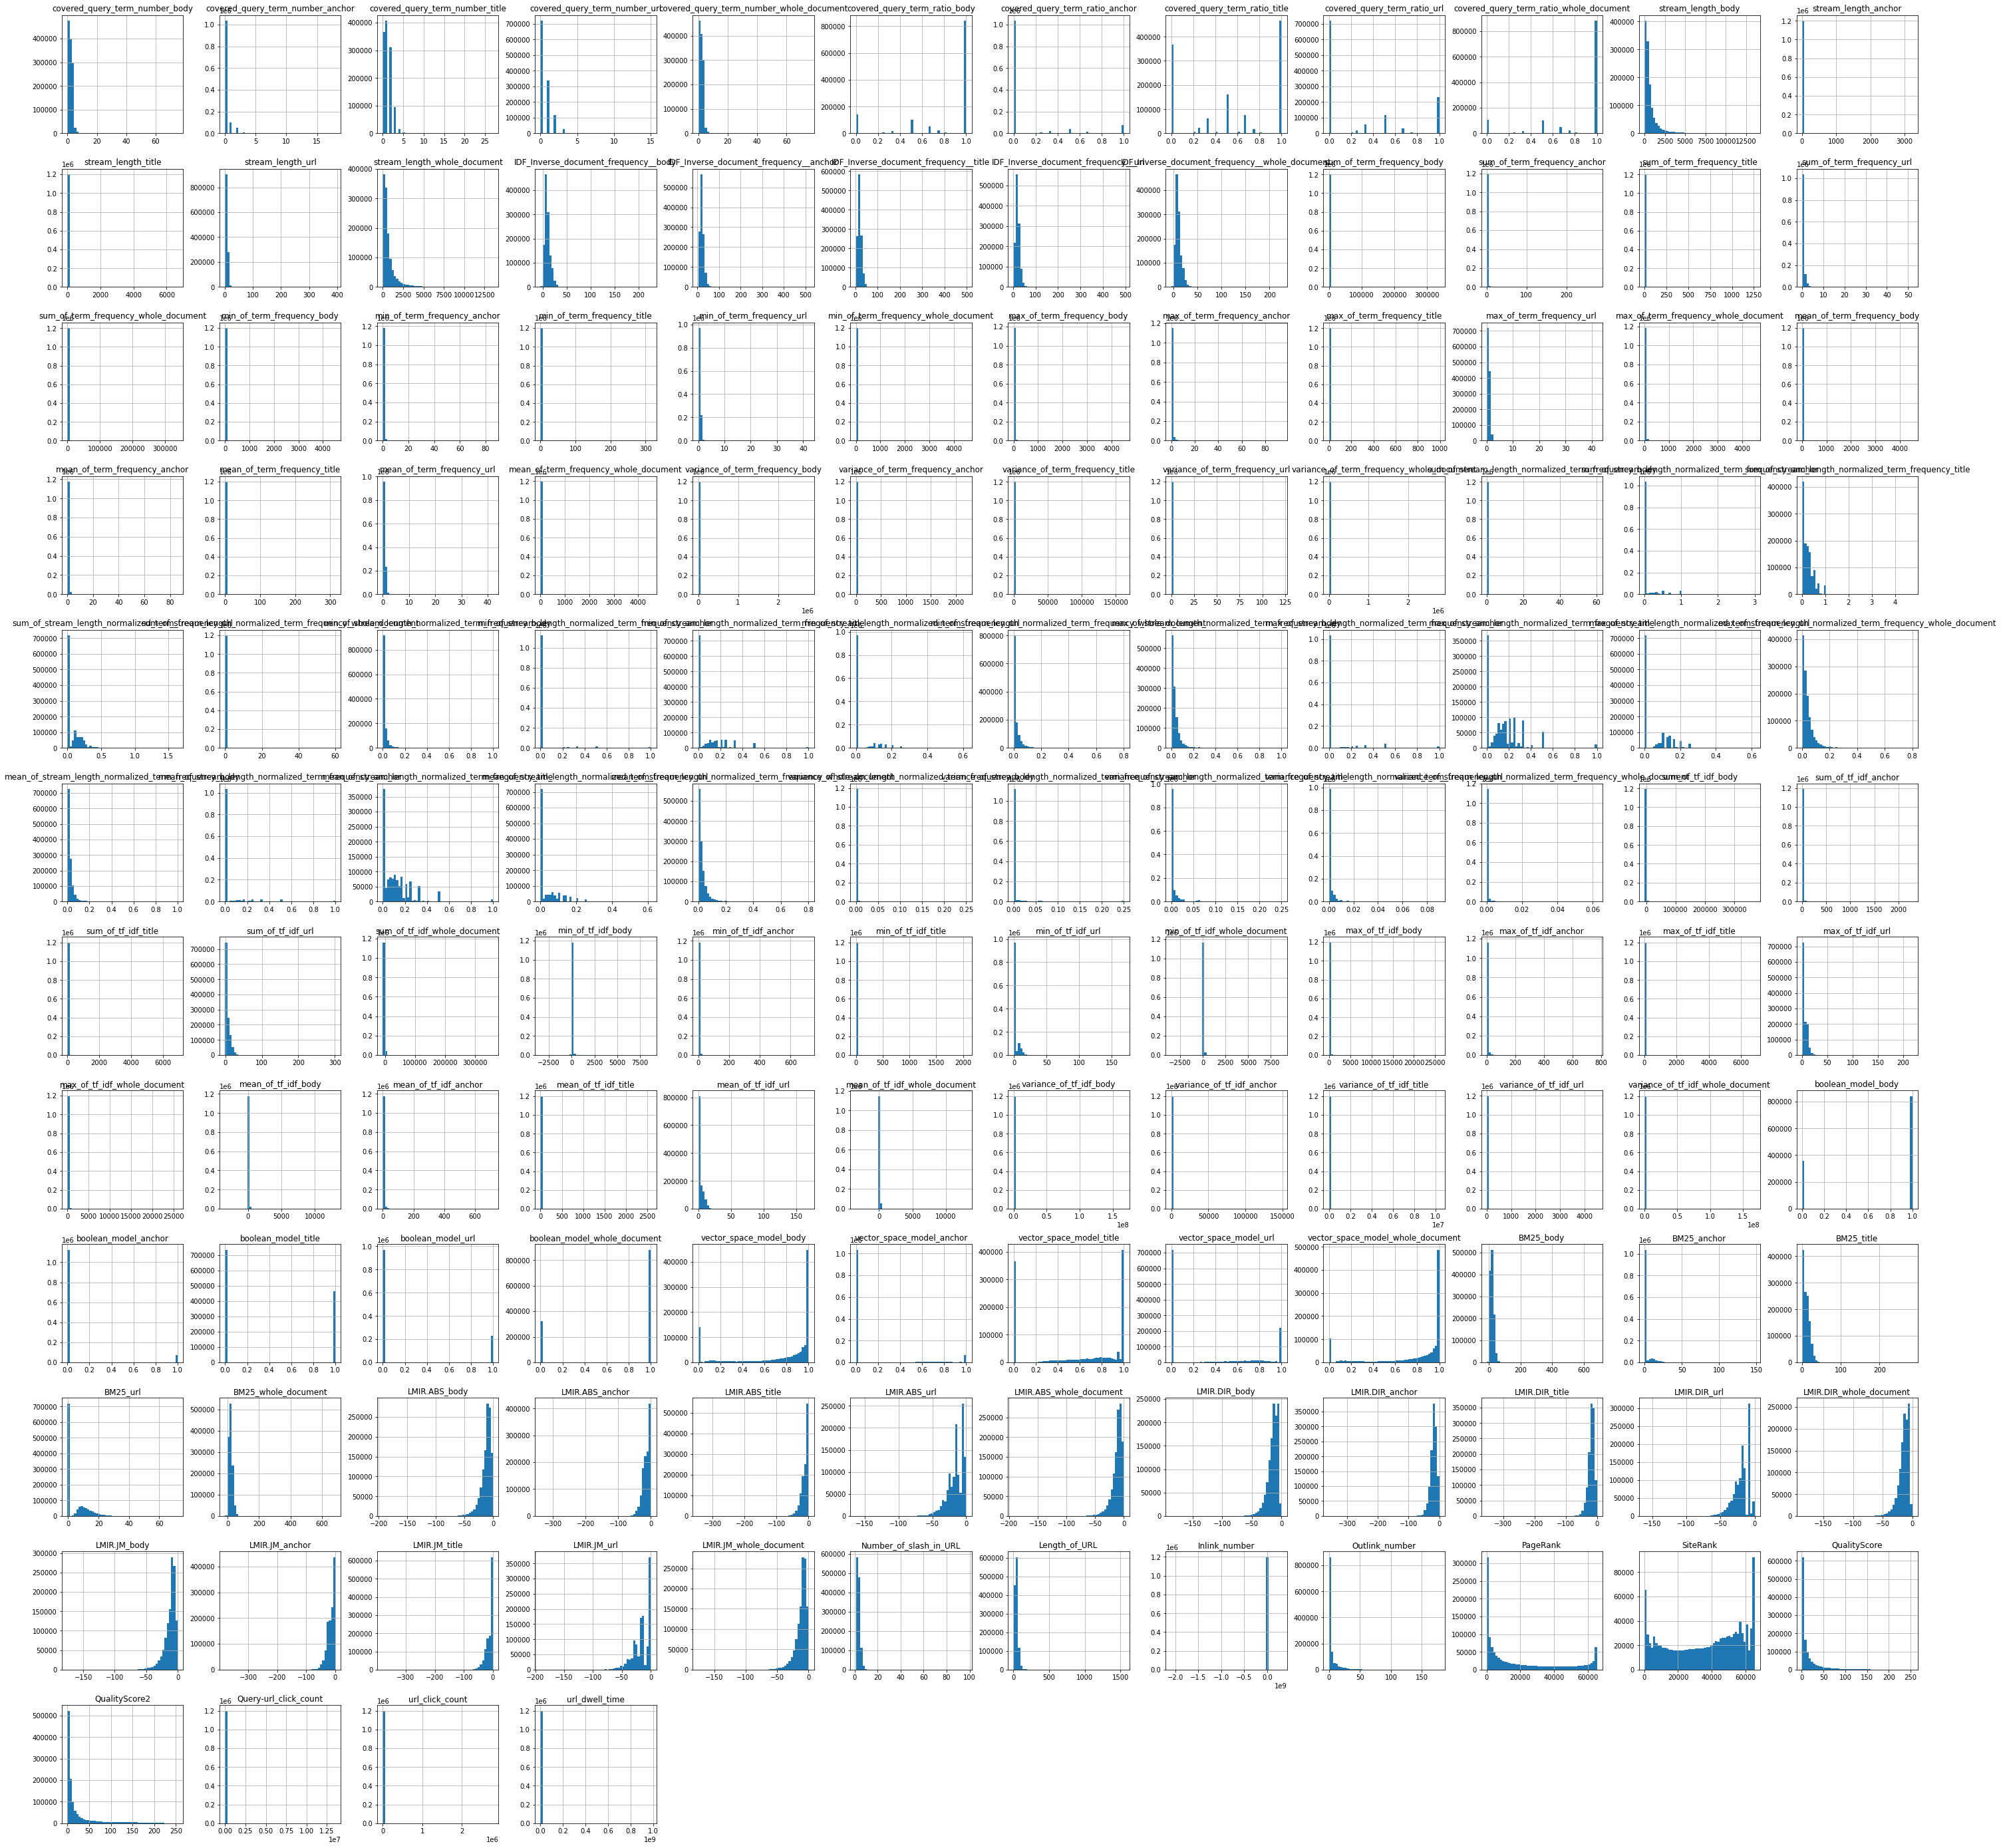

In [15]:
df = build_complete_dataset(3)
df_features = df[df.columns[2:]]
df_features.hist(figsize=(50,50), bins=50);

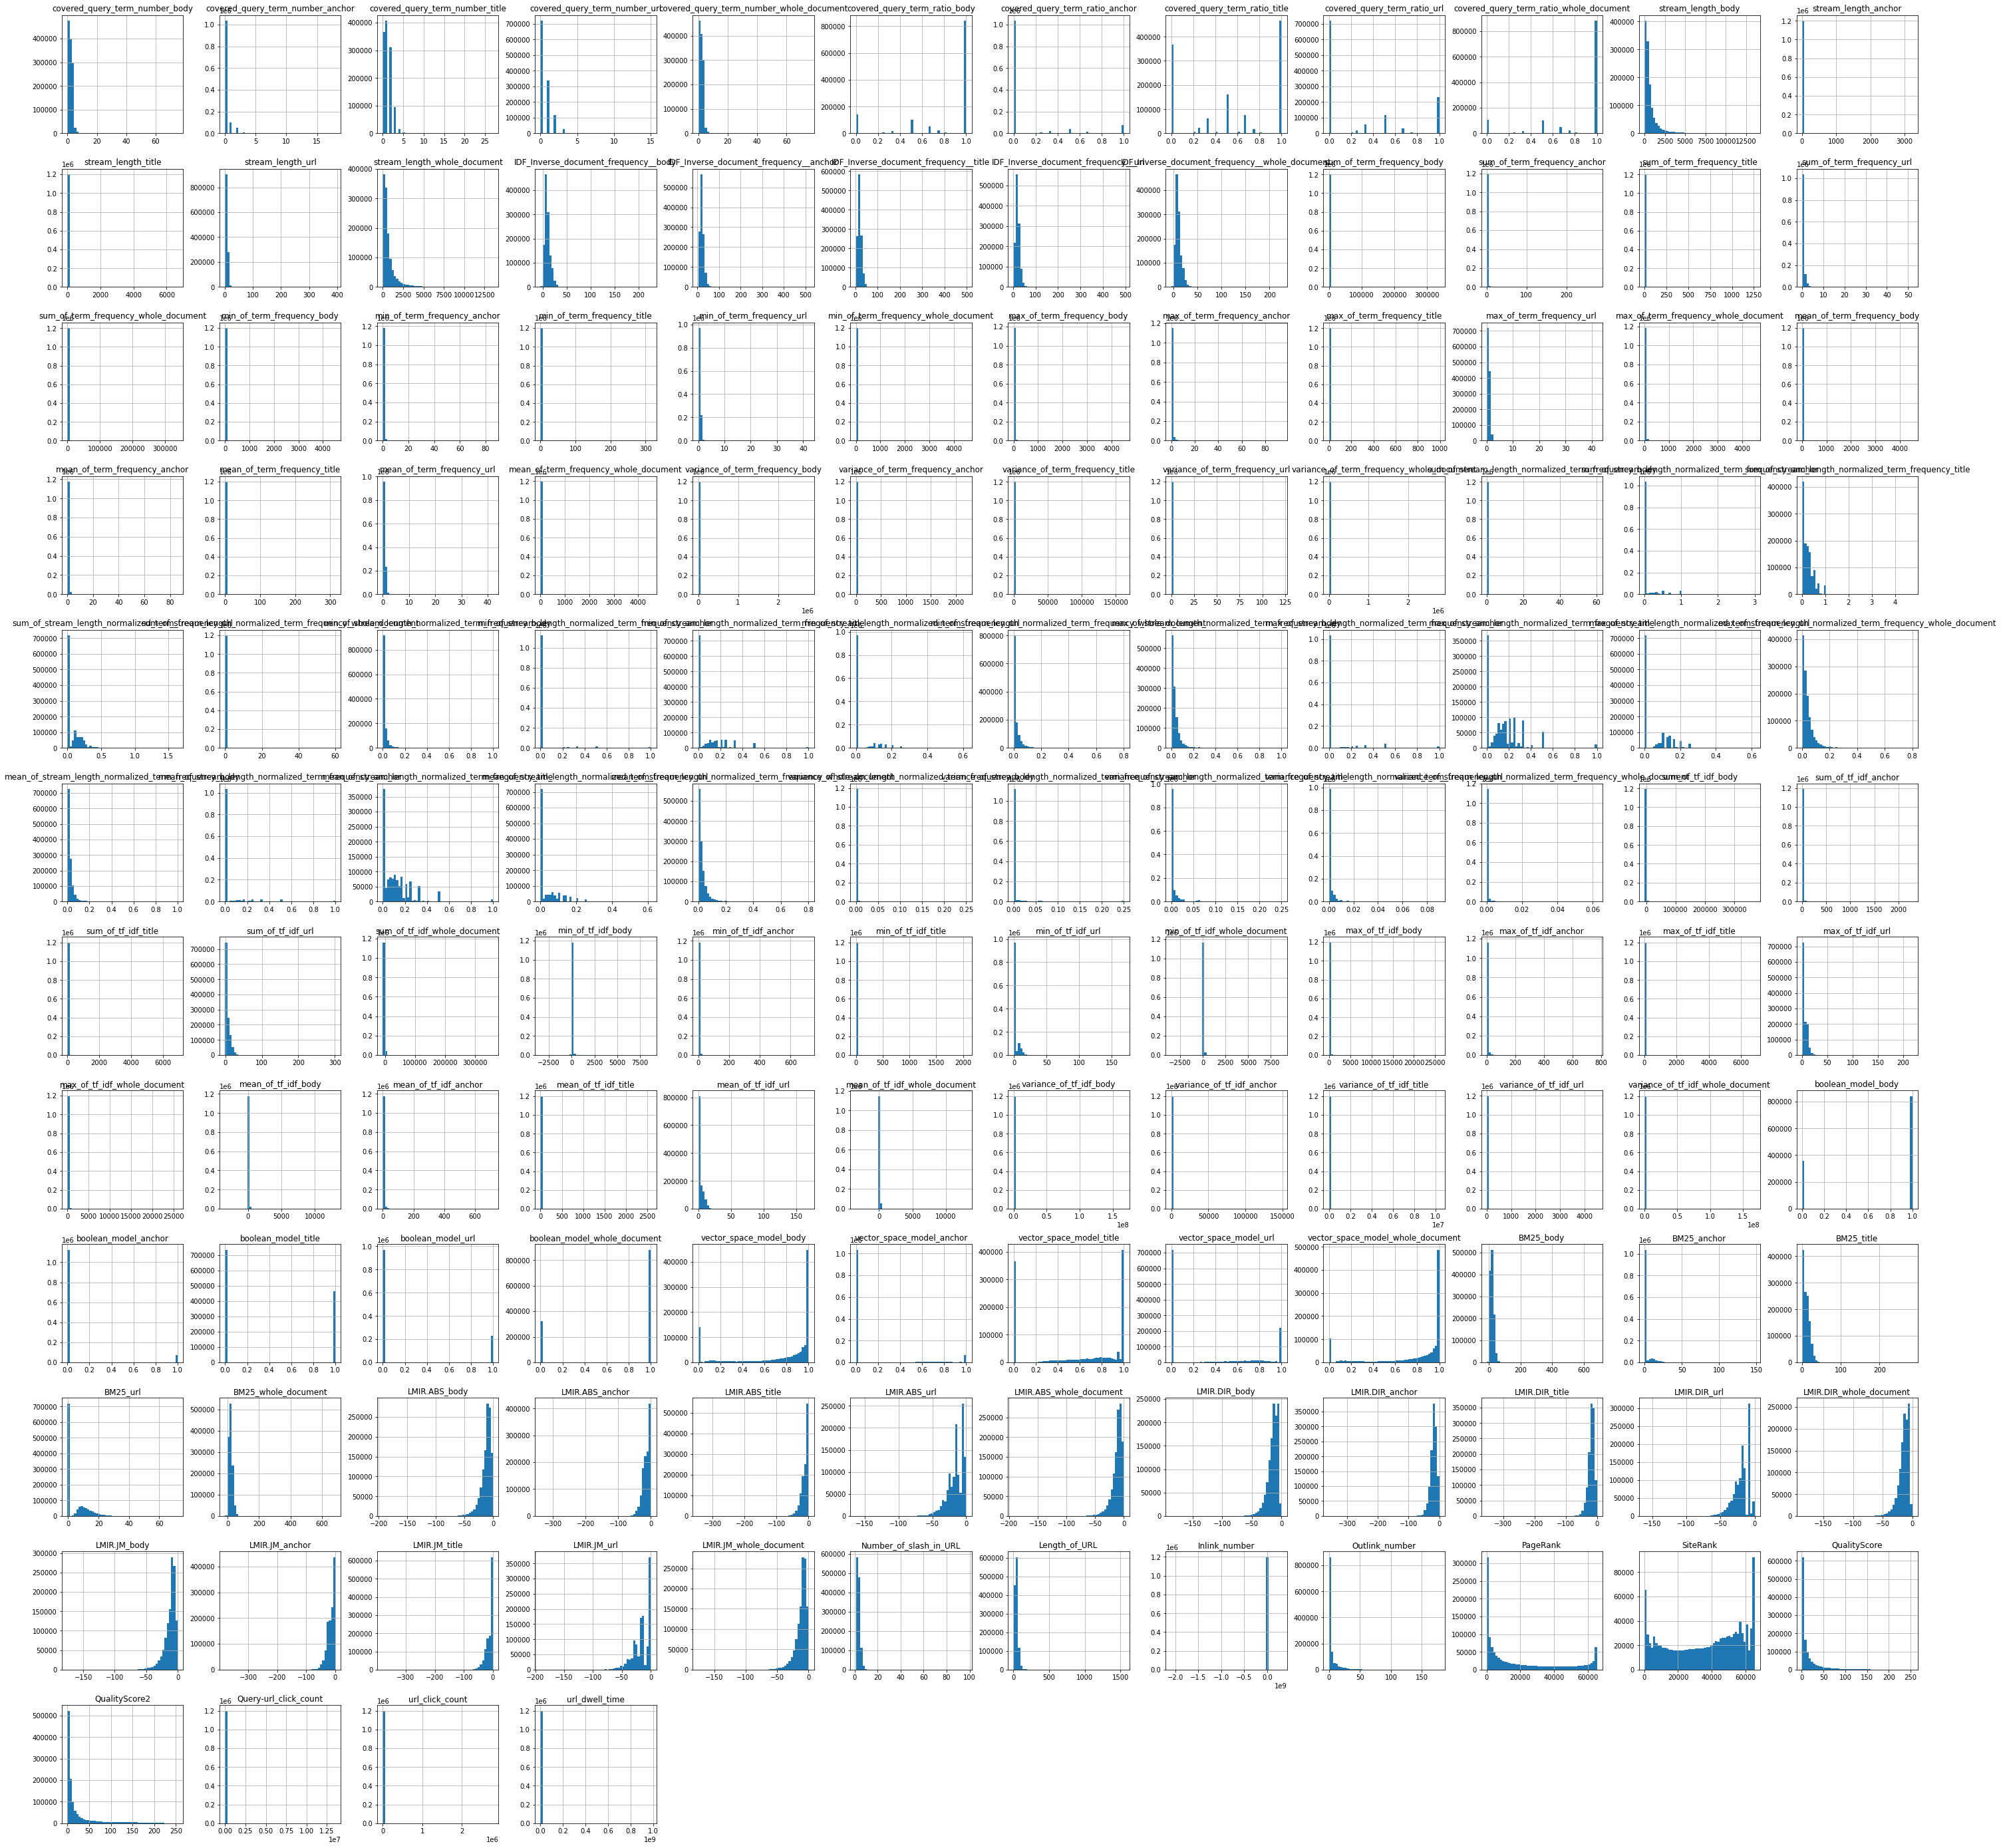

In [16]:
df = build_complete_dataset(5)
df_features = df[df.columns[2:]]
df_features.hist(figsize=(50,50), bins=50);

#### Looking at the above distributions of the features, you can see a vast amount of outliers which can also been seen in the below cell when calling the describe() function. With the skewed data across the dataset we will need to implement some form of scaling before or during the modeling phase.

In [17]:
df_features.describe()

,covered_query_term_number_body,covered_query_term_number_anchor,covered_query_term_number_title,covered_query_term_number_url,covered_query_term_number_whole_document,covered_query_term_ratio_body,covered_query_term_ratio_anchor,covered_query_term_ratio_title,covered_query_term_ratio_url,covered_query_term_ratio_whole_document,stream_length_body,stream_length_anchor,stream_length_title,stream_length_url,stream_length_whole_document,IDF_Inverse_document_frequency__body,IDF_Inverse_document_frequency__anchor,IDF_Inverse_document_frequency__title,IDF_Inverse_document_frequency__url,IDF_Inverse_document_frequency__whole_document,sum_of_term_frequency_body,sum_of_term_frequency_anchor,sum_of_term_frequency_title,sum_of_term_frequency_url,sum_of_term_frequency_whole_document,min_of_term_frequency_body,min_of_term_frequency_anchor,min_of_term_frequency_title,min_of_term_frequency_url,min_of_term_frequency_whole_document,max_of_term_frequency_body,max_of_term_frequency_anchor,max_of_term_frequency_title,max_of_term_frequency_url,max_of_term_frequency_whole_document,mean_of_term_frequency_body,mean_of_term_frequency_anchor,mean_of_term_frequency_title,mean_of_term_frequency_url,mean_of_term_frequency_whole_document,variance_of_term_frequency_body,variance_of_term_frequency_anchor,variance_of_term_frequency_title,variance_of_term_frequency_url,variance_of_term_frequency_whole_document,sum_of_stream_length_normalized_term_frequency_body,sum_of_stream_length_normalized_term_frequency_anchor,sum_of_stream_length_normalized_term_frequency_title,sum_of_stream_length_normalized_term_frequency_url,sum_of_stream_length_normalized_term_frequency_whole_document,min_of_stream_length_normalized_term_frequency_body,min_of_stream_length_normalized_term_frequency_anchor,min_of_stream_length_normalized_term_frequency_title,min_of_stream_length_normalized_term_frequency_url,min_of_stream_length_normalized_term_frequency_whole_document,max_of_stream_length_normalized_term_frequency_body,max_of_stream_length_normalized_term_frequency_anchor,max_of_stream_length_normalized_term_frequency_title,max_of_stream_length_normalized_term_frequency_url,max_of_stream_length_normalized_term_frequency_whole_document,mean_of_stream_length_normalized_term_frequency_body,mean_of_stream_length_normalized_term_frequency_anchor,mean_of_stream_length_normalized_term_frequency_title,mean_of_stream_length_normalized_term_frequency_url,mean_of_stream_length_normalized_term_frequency_whole_document,variance_of_stream_length_normalized_term_frequency_body,variance_of_stream_length_normalized_term_frequency_anchor,variance_of_stream_length_normalized_term_frequency_title,variance_of_stream_length_normalized_term_frequency_url,variance_of_stream_length_normalized_term_frequency_whole_document,sum_of_tf_idf_body,sum_of_tf_idf_anchor,sum_of_tf_idf_title,sum_of_tf_idf_url,sum_of_tf_idf_whole_document,min_of_tf_idf_body,min_of_tf_idf_anchor,min_of_tf_idf_title,min_of_tf_idf_url,min_of_tf_idf_whole_document,max_of_tf_idf_body,max_of_tf_idf_anchor,max_of_tf_idf_title,max_of_tf_idf_url,max_of_tf_idf_whole_document,mean_of_tf_idf_body,mean_of_tf_idf_anchor,mean_of_tf_idf_title,mean_of_tf_idf_url,mean_of_tf_idf_whole_document,variance_of_tf_idf_body,variance_of_tf_idf_anchor,variance_of_tf_idf_title,variance_of_tf_idf_url,variance_of_tf_idf_whole_document,boolean_model_body,boolean_model_anchor,boolean_model_title,boolean_model_url,boolean_model_whole_document,vector_space_model_body,vector_space_model_anchor,vector_space_model_title,vector_space_model_url,vector_space_model_whole_document,BM25_body,BM25_anchor,BM25_title,BM25_url,BM25_whole_document,LMIR.ABS_body,LMIR.ABS_anchor,LMIR.ABS_title,LMIR.ABS_url,LMIR.ABS_whole_document,LMIR.DIR_body,LMIR.DIR_anchor,LMIR.DIR_title,LMIR.DIR_url,LMIR.DIR_whole_document,LMIR.JM_body,LMIR.JM_anchor,LMIR.JM_title,LMIR.JM_url,LMIR.JM_whole_document,Number_of_slash_in_URL,Length_of_URL,Inlink_number,Outlink_number,PageRank,SiteRank,QualityScore,Quality

#### Convert CSV to TFRecord for modeling efficiency

##### Converting the csv or txt files to TFRecords will significantly increase performance when training the model. Also, this is the only method for injesting data into the TensorFlow Ranking pipeline.

##### The class SVM_to_TFRecord can be viewed in the tfrecord_converter_.py file. The overall structure is as follows:
    
   * Load the .txt files as [sklearn.datasets.load_svmlight_file](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_svmlight_file.html). The svmlight_file will improve efficiency during the conversion to TFRecords. 
   * Concatenate svmlight_file into a numpy array. This creates an array containing all features, relevance labels, and query id's.
   * Create TFRecord grouped by query id. Grouping the TFRecord by Query ID if the first major decision in models architecture as the data will be fed in a **List Wise** approach. This will be discussed in more depth when answering the questions at the end of this notebook. 

##### The below class converts all files from .txt to TFRecords. The class can be viewed in the tfrecord_converter_.py file.



In [18]:
data_path = ['Fold1', 'Fold2', 'Fold3', 'Fold4', 'Fold5']

for data in data_path:
    path = f"tfrecord_{data.lstrip('Fold')}"
    converter = SVM_to_TFRecord(data,path)
    converter.load_and_convert_data()
    print(f'Completed {data}/{path}')

Completed Fold1/tfrecord_1
Completed Fold2/tfrecord_2
Completed Fold3/tfrecord_3
Completed Fold4/tfrecord_4
Completed Fold5/tfrecord_5


### 4) Build ranking model

In [2]:
build_model(model_dir='base_model_no_preprocessing')

Data types of partitions are different! Please refer to the troubleshooting section of the Modin documentation to fix this issue.
2022-04-06 15:01:58.702430: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 15:01:58.746056: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 15:01:58.746200: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-06 15:01:58.747052: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in per

Epoch 1/5


2022-04-06 15:02:11.445416: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


5000/5000 [==============================] - 306s 61ms/step - loss: -0.5598 - metric/ndcg_1: 0.1493 - metric/ndcg_5: 0.1820 - metric/ndcg_10: 0.2137 - metric/ndcg: 0.5633 - val_loss: -0.5613 - val_metric/ndcg_1: 0.1928 - val_metric/ndcg_5: 0.2110 - val_metric/ndcg_10: 0.2365 - val_metric/ndcg: 0.5757
Epoch 2/5
5000/5000 [==============================] - 271s 54ms/step - loss: -0.5731 - metric/ndcg_1: 0.1742 - metric/ndcg_5: 0.2039 - metric/ndcg_10: 0.2341 - metric/ndcg: 0.5750 - val_loss: -0.5745 - val_metric/ndcg_1: 0.1960 - val_metric/ndcg_5: 0.2224 - val_metric/ndcg_10: 0.2537 - val_metric/ndcg: 0.5861
Epoch 3/5
5000/5000 [==============================] - 275s 55ms/step - loss: -0.5825 - metric/ndcg_1: 0.1921 - metric/ndcg_5: 0.2203 - metric/ndcg_10: 0.2499 - metric/ndcg: 0.5842 - val_loss: -0.5873 - val_metric/ndcg_1: 0.2354 - val_metric/ndcg_5: 0.2475 - val_metric/ndcg_10: 0.2752 - val_metric/ndcg: 0.5991
Epoch 4/5
5000/5000 [==============================] - 274s 55ms/step - lo

2022-04-06 15:25:31.722586: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: base_model_no_preprocessing/export/latest_model/assets


INFO:tensorflow:Assets written to: base_model_no_preprocessing/export/latest_model/assets


In [3]:
build_model(preprocessor=True, model_dir='base_model_with_preprocessing')

Epoch 1/5
5000/5000 [==============================] - 305s 61ms/step - loss: -0.6771 - metric/ndcg_1: 0.4124 - metric/ndcg_5: 0.4067 - metric/ndcg_10: 0.4249 - metric/ndcg: 0.6782 - val_loss: -0.6931 - val_metric/ndcg_1: 0.4457 - val_metric/ndcg_5: 0.4345 - val_metric/ndcg_10: 0.4546 - val_metric/ndcg: 0.6944
Epoch 2/5
5000/5000 [==============================] - 280s 56ms/step - loss: -0.6880 - metric/ndcg_1: 0.4356 - metric/ndcg_5: 0.4246 - metric/ndcg_10: 0.4427 - metric/ndcg: 0.6887 - val_loss: -0.6937 - val_metric/ndcg_1: 0.4416 - val_metric/ndcg_5: 0.4351 - val_metric/ndcg_10: 0.4551 - val_metric/ndcg: 0.6947
Epoch 3/5
5000/5000 [==============================] - 276s 55ms/step - loss: -0.6911 - metric/ndcg_1: 0.4429 - metric/ndcg_5: 0.4303 - metric/ndcg_10: 0.4479 - metric/ndcg: 0.6918 - val_loss: -0.6927 - val_metric/ndcg_1: 0.4388 - val_metric/ndcg_5: 0.4344 - val_metric/ndcg_10: 0.4521 - val_metric/ndcg: 0.6936
Epoch 4/5
5000/5000 [==============================] - 267s 53ms

INFO:tensorflow:Assets written to: base_model_with_preprocessing/export/latest_model/assets


In [4]:
build_model(preprocessor=True, model_dir='base_model_with_preprocessing_gumbell', loss='gumbel_approx_ndcg_loss')

Epoch 1/5
5000/5000 [==============================] - 315s 63ms/step - loss: -0.6751 - metric/ndcg_1: 0.4135 - metric/ndcg_5: 0.4083 - metric/ndcg_10: 0.4267 - metric/ndcg: 0.6795 - val_loss: -0.6921 - val_metric/ndcg_1: 0.4457 - val_metric/ndcg_5: 0.4371 - val_metric/ndcg_10: 0.4561 - val_metric/ndcg: 0.6956
Epoch 2/5
5000/5000 [==============================] - 274s 55ms/step - loss: -0.6893 - metric/ndcg_1: 0.4420 - metric/ndcg_5: 0.4316 - metric/ndcg_10: 0.4495 - metric/ndcg: 0.6924 - val_loss: -0.6951 - val_metric/ndcg_1: 0.4500 - val_metric/ndcg_5: 0.4427 - val_metric/ndcg_10: 0.4610 - val_metric/ndcg: 0.6979
Epoch 3/5
5000/5000 [==============================] - 270s 54ms/step - loss: -0.6934 - metric/ndcg_1: 0.4525 - metric/ndcg_5: 0.4391 - metric/ndcg_10: 0.4563 - metric/ndcg: 0.6963 - val_loss: -0.6943 - val_metric/ndcg_1: 0.4465 - val_metric/ndcg_5: 0.4386 - val_metric/ndcg_10: 0.4586 - val_metric/ndcg: 0.6972
Epoch 4/5
5000/5000 [==============================] - 277s 55ms

INFO:tensorflow:Assets written to: base_model_with_preprocessing_gumbell/export/latest_model/assets


### 5) Evaluate model performance

In [5]:
# Build Test Dataset for Model Ingestion

features = preprocess_features()
feature_cols = np.array(features['cols'])

# Create specs for pipeline
context_spec_ = {}
example_spec_ = {feat: tf.io.FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=0.0) for feat in feature_cols}
label_spec_ = ('relevance_label', tf.io.FixedLenFeature(shape=(1,), dtype=tf.int64, default_value=-1))

dataset_hparams = tfr.keras.pipeline.DatasetHparams(
    train_input_pattern='tfrecord_1/train.tfrecords',
    valid_input_pattern='tfrecord_1/test.tfrecords',
    train_batch_size=128,
    valid_batch_size=128,
    list_size=200,
    dataset_reader=tfr.keras.pipeline.DatasetHparams.dataset_reader)

# Define Dataset Builder
dataset_builder = tfr.keras.pipeline.SimpleDatasetBuilder(
    {},
    example_spec_,
    mask_feature_name="example_list_mask",
    label_spec=label_spec_,
    hparams=dataset_hparams,
    sample_weight_spec=None)

ds = dataset_builder.build_valid_dataset()

model_no_preprocessing = tf.keras.models.load_model('base_model_no_preprocessing/export/latest_model')
model_with_preprocessing = tf.keras.models.load_model('base_model_with_preprocessing/export/latest_model/')
model_with_preprocessing_gumbell = tf.keras.models.load_model('base_model_with_preprocessing_gumbell/export/latest_model/')

loss_no_preprocessing = model_no_preprocessing.evaluate(ds.take(2000))
loss_with_preprocessing = model_with_preprocessing.evaluate(ds.take(2000))
loss_with_preprocessing_gumbell = model_with_preprocessing_gumbell.evaluate(ds.take(2000))

no_preprocessing = pd.DataFrame(loss_no_preprocessing, columns=['No_Preprocessing'], index=['Loss', 'NDCG_1', 'NDCG_5', 'NDCG_10', 'NDCG']).T
with_preprocessing = pd.DataFrame(loss_with_preprocessing, columns=['With_Preprocessing'], index=['Loss', 'NDCG_1', 'NDCG_5', 'NDCG_10', 'NDCG']).T
gumbell = pd.DataFrame(loss_with_preprocessing_gumbell, columns=['With_Preprocessing_Gumbell'], index=['Loss', 'NDCG_1', 'NDCG_5', 'NDCG_10', 'NDCG']).T

final_results = pd.concat([no_preprocessing, with_preprocessing, gumbell])

2000/2000 [==============================] - 118s 58ms/step - loss: -0.6926 - metric/ndcg_1: 0.4465 - metric/ndcg_5: 0.4407 - metric/ndcg_10: 0.4590 - metric/ndcg: 0.6952


In [6]:
final_results

,Loss,NDCG_1,NDCG_5,NDCG_10,NDCG
No_Preprocessing,-0.596766,0.248900,0.272480,0.302138,0.609684
With_Preprocessing,-0.691506,0.442676,0.436977,0.452354,0.692168
With_Preprocessing_Gumbell,-0.692600,0.446523,0.440701,0.459009,0.695216


In [7]:
# Evaluate model performance
%load_ext tensorboard

%tensorboard --logdir base_model_no_preprocessing/

In [8]:
%tensorboard --logdir base_model_with_preprocessing/

# Discussion

In [9]:
final_results

,Loss,NDCG_1,NDCG_5,NDCG_10,NDCG
No_Preprocessing,-0.596766,0.248900,0.272480,0.302138,0.609684
With_Preprocessing,-0.691506,0.442676,0.436977,0.452354,0.692168
With_Preprocessing_Gumbell,-0.692600,0.446523,0.440701,0.459009,0.695216


### 6) Please answer the following questions about your choices:

- Discuss your model and why you chose the model you chose (eg architecture, design, loss functions, etc)

   * For this project, I chose to implement a listwise approach as this method generally outperforms the simpler pairwise approach. The models architecture consists of three hideen layers with size of 1024, 512, 256 with ReLU activation and batch normalization after each layer. The models architecture was selected from [this Google research paper](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/03d9dbc56c3d1b19a611043a4cb72e227ebba249.pdf) which shows the power of feature transofrmation. My goal was to duplicate their results with the smaller Web10k dataset. With the smaller overall architecture, I chose to use ReLU activation as I wasn't overly concerned with dying ReLU's. If the model was deep, it would be worth the extra effort to investigate the effects of ELU or SELU activations on each layer. After digging into the different loss methods in Learning To Rank (LTR) system's, I found NDCG to be the go-to when dealing with graded relevance labels. With this in mind, I found approx_ndcg_loss and gumbel_approx_ndcg_loss to be appropriate. The Gumbel loss outperformed the standard ndcg loss so this would be the preferred method moving forward. 
   
<br/>


- Why did you choose your metric to evaluate the model?

    * I chose the NDCG metric at topn 1, 5, and 10. This metric is not seen in the above code due the TFRanking's default implementation of this metric when using their pipeline feature. Again, this metric is the go-to choice when dealing with graded relevance labels and is well suited for listwise applications.

* How well would you say your model performed?

    * I would say that the model performed well for the amount of training that was completed. I was able to duplicate the results from Google's research paper and show the effect of feature transformations in LTR systems. On the other hand, I think that there is room for growth in these models. 
<br/>

* If you had more time what else would you want to try?
    
    * If I had more time, I would like to try gradient boosted tree algorithms such as RANKNet or other alternatives seen [here](https://en.wikipedia.org/wiki/Learning_to_rank#cite_note-liu-1). The Wikipedia page has 20+ relevant LTR strategies with research papers attached. With the competitive research between boosted tree algorithms and neural nets, it would be great to attempt alternative solutions.
    
    * The feature transformation (FT) technique that I chose (log1p) came from the TFRanking library which is a simple yet powerful way to showcase the strength of FT's. The above Goolge paper implements a Mixture of FT's which showcases an improvement from the log1p transformation. It would be advantageous to integrate this FT into the model to improve performance. 

### 7) Please answer the following questions about how you would use additional features:

*  If you had an additional feature for each row of the dataset that was unique identifier for the user performing the query e.g. `user_id`, how could you use it to improve the performance of the model?
    * With the current model architecture in place, the simplest way would be to add the "user_id" as a contextual feature and utilize a Self-Attentive Document Interaction Network (DIN) which will allow for cross-document interactions. Reviewing [Google's research](https://arxiv.org/pdf/1910.09676.pdf), specifically Table 1, you can see significant improvement on the Web30k dataset which is the larger form of the dataset used in this project. The implementation of the DIN network will need further investigation but, based on my review, seems like the best approach. 
<br/>
<br/>
*  If you had the additional features of: `query_text` or the actual textual query itself, as well as document text features like `title_text`, `body_text`, `anchor_text`, `url` for the document, how would you include them in your model (or any model) to improve its performance?

    * Based on [TFRanking's documentation](https://www.tensorflow.org/ranking/overview), I would integrate the additional text features make use of the integrated TFR-BERT library. Another avenue I would investigate is the DeText approached taken by LinkedIn in this [paper](https://arxiv.org/pdf/2008.02460.pdf).